In [1]:
import numpy as np
import PitchControlNew as mpc
import VizNew as mviz
import pandas as pd

In [2]:
#read in the tracking data for liverpool and the opposition
tracking_homenew = pd.read_csv('liverpool_tracking.csv')
tracking_awaynew = pd.read_csv('opposition_tracking.csv')

In [3]:
params = mpc.default_model_params(3)

In [4]:
#function to find the attacker in Liverpool data who will reach the target_position in the least time
def nearest_attackerliv(target_position, frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    pass_frame = frame
    pass_team = 'Away'
    if pass_team=='Home':
        attacking_players = mpc.initialise_players(tracking_homenew.loc[pass_frame],'Home',params)
        defending_players = mpc.initialise_players(tracking_awaynew.loc[pass_frame],'Away',params)
    elif pass_team=='Away':
        defending_players = mpc.initialise_players(tracking_homenew.loc[pass_frame],'Home',params)
        attacking_players = mpc.initialise_players(tracking_awaynew.loc[pass_frame],'Away',params)
    else:
        assert False, "Team in possession must be either home or away"

    nearest_att = np.nanargmin( [p.simple_time_to_intercept(target_position ) for p in attacking_players] )
    return attacking_players[nearest_att].__dict__['id']

In [5]:
#function to find x-coordinate of deepest opposition defender
def last_defliv(f,tracking_homenew):
    u = 'Away'
    if u == "Away":
        a1 = tracking_homenew.iloc[f].Home_1_x
        a2 = tracking_homenew.iloc[f].Home_2_x
        a3 = tracking_homenew.iloc[f].Home_3_x
        a4 = tracking_homenew.iloc[f].Home_4_x
        a5 = tracking_homenew.iloc[f].Home_5_x
        a6 = tracking_homenew.iloc[f].Home_6_x
        a7 = tracking_homenew.iloc[f].Home_7_x
        a8 = tracking_homenew.iloc[f].Home_8_x   
        a9 = tracking_homenew.iloc[f].Home_9_x 
        a10 = tracking_homenew.iloc[f].Home_10_x
        a11 = tracking_homenew.iloc[f].Home_11_x
        a12 = tracking_homenew.iloc[f].Home_12_x
        a13 = tracking_homenew.iloc[f].Home_13_x
        a14 = tracking_homenew.iloc[f].Home_14_x
        x=[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14]
        x = np.array(x)
        x[np.isnan(x)] = 0
        m = np.partition(x, 12)[12]

    return m
                   

In [6]:
def find1(PP,frame,tracking_home,tracking_away,xgrid,ygrid,last):
    for k in range(0,49):
        for i in range(0,31):
            l = (nearest_attackerliv(np.array( [xgrid[k], ygrid[i]] ),frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50))
            l=l.astype(int)
            if (locx[i][k]>last) and (PP[i][k]>0.5):
                zero[i][k] = zero[i][k]+PP[i][k]
    return

In [7]:
#iterations is number of frames analysed
#interval is difference between two consecutive frames looked at, could be 1,2,3,....
#starting_frame is the first frame to be looked at
def liverpool_pitch_control_behind_defence(iterations, interval, starting_frame,tracking_homenew, tracking_awaynew, params):
    for j in range(0, iterations):
        k = starting_frame + j*interval
        frame_id = k
        last = last_defliv(frame_id,tracking_homenew)
        p = 'Away'
        PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_frameliv(frame_id, tracking_homenew, tracking_awaynew, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
        find1(PPCF,frame_id,tracking_homenew,tracking_awaynew,xgrid,ygrid,last)

In [8]:
#to plot pitch control behind defence 
def plot_pitch_control(zero):
    import matplotlib as mpl
    from matplotlib import pyplot
    import numpy as np


    fig = pyplot.figure(2)

    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['green','yellow','orange','red'],
                                           256)

    img2 = pyplot.imshow(zero[:,0:49][0:31],interpolation='nearest',cmap = cmap2,origin='lower')

    pyplot.colorbar(img2,cmap=cmap2)

    fig.savefig("new.png",dpi=600)#save the plot on your desktop



(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a0c95f8>)

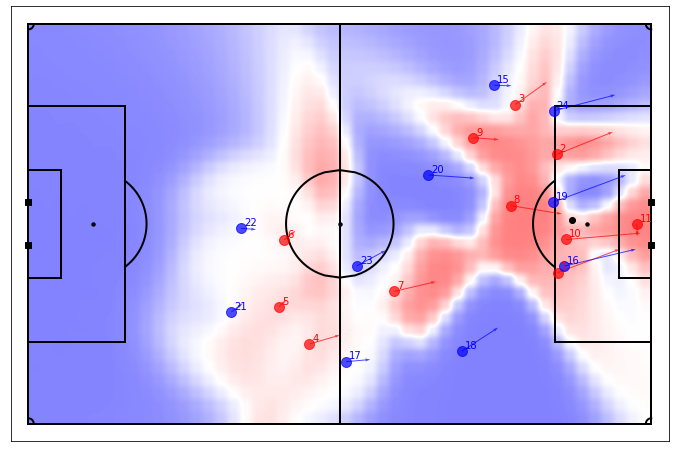

In [9]:

frame = 2500 #for finding out pitch control at that instant
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_frameliv(frame, tracking_homenew, tracking_awaynew, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_frameliv(frame,  tracking_homenew, tracking_awaynew, PPCF, xgrid, ygrid, annotate=True )



In [ ]:
#code for pitch control video, change the starting_frame and end_frame as needed
#here the last goal is accessed
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import math
starting_frame = 2375
end_frame = 2541
f = 20
def make_frame(t):
    t2 = int(math.ceil(t*f+0.0001)-1)
    #print(t ,t2+starting_frame, 'dscsd')
    PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_frameliv(t2+starting_frame, tracking_homenew, tracking_awaynew, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
    fig, ax = mviz.plot_pitchcontrol_for_frameliv(t2+starting_frame,  tracking_homenew, tracking_awaynew, PPCF, xgrid, ygrid, annotate=True ) 
    image = mplfig_to_npimage(fig)
    return image # returns a 8-bit RGB array

clip = mpy.VideoClip(make_frame, duration=((end_frame-starting_frame)/f)).set_fps(f) # 2 seconds
clip.ipython_display()
clip.write_videofile("video.mp4")#video file is saved

In [38]:
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_frameliv(2375, tracking_homenew, tracking_awaynew, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
locx = PPCF.copy()
zero = PPCF.copy()

for k in range(0, 50):
    for i in range(0,32):
        locx[i][k] = xgrid[k]
        zero[i][k] = 0

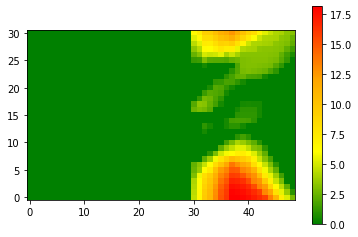

In [39]:
#to plot pitch control behind defence for a particular 20 frames starting from 1, with jump of 5 frames each time
iterations = 20
interval = 5
starting_frame = 2375
for k in range(0, 50):
    for i in range(0,32):
        zero[i][k] = 0
liverpool_pitch_control_behind_defence(iterations,interval,starting_frame,tracking_homenew, tracking_awaynew, params)
plot_pitch_control(zero)
